## Add Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import splitfolders
import os
import shutil

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.applications import VGG16

## Read In Data

In [2]:
df = pd.read_csv("data/pokedex.csv", index_col=0)
df

,dex_no,image,name,type1,type2,image_name
0,1,https://img.pokemondb.net/sprites/home/normal/...,Bulbasaur,Grass,Poison,bulbasaur.jpg
1,2,https://img.pokemondb.net/sprites/home/normal/...,Ivysaur,Grass,Poison,ivysaur.jpg
2,3,https://img.pokemondb.net/sprites/home/normal/...,Venusaur,Grass,Poison,venusaur.jpg
3,4,https://img.pokemondb.net/sprites/home/normal/...,Charmander,Fire,NaN,charmander.jpg
4,5,https://img.pokemondb.net/sprites/home/normal/...,Charmeleon,Fire,NaN,charmeleon.jpg
...,...,...,...,...,...,...
1005,1006,https://img.pokemondb.net/sprites/scarlet-viol...,Iron Valiant,Fairy,Fighting,iron-valiant.png
1006,1007,https://img.pokemondb.net/sprites/scarlet-viol...,Koraidon,Fighting,Dragon,koraidon.png
1007,1008,https://img.pokemondb.net/sprites/scarlet-viol...,Miraidon,Electric,Dragon,miraidon.png
1008,1009,https://img.pokemondb.net/sprites/scarlet-viol...,Walking Wake,Water,Dragon,walking-wake.png


## Split Folders for Train-Test and By Class

In [4]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.1,0.1)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)
    
val_list = []
for image in os.listdir("train_test_folders/val/images"):
    val_list.append(image)
    
# note in dataframe which folder image is in
train_df = df.loc[df.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = df.loc[df.apply(lambda row: row["image_name"] in test_list, axis=1)]
val_df = df.loc[df.apply(lambda row: row["image_name"] in val_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"
val_df["split"] = "val"

pdList = [train_df, test_df, val_df]
df = pd.concat(pdList)
df

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_20489/2429589536.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["split"] = "train"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_20489/2429589536.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["split"] = "test"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_20489/2429589536.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,dex_no,image,name,type1,type2,image_name,split
0,1,https://img.pokemondb.net/sprites/home/normal/...,Bulbasaur,Grass,Poison,bulbasaur.jpg,train
1,2,https://img.pokemondb.net/sprites/home/normal/...,Ivysaur,Grass,Poison,ivysaur.jpg,train
2,3,https://img.pokemondb.net/sprites/home/normal/...,Venusaur,Grass,Poison,venusaur.jpg,train
3,4,https://img.pokemondb.net/sprites/home/normal/...,Charmander,Fire,NaN,charmander.jpg,train
4,5,https://img.pokemondb.net/sprites/home/normal/...,Charmeleon,Fire,NaN,charmeleon.jpg,train
...,...,...,...,...,...,...,...
941,942,https://img.pokemondb.net/sprites/scarlet-viol...,Maschiff,Dark,NaN,maschiff.png,val
951,952,https://img.pokemondb.net/sprites/scarlet-viol...,Scovillain,Grass,Fire,scovillain.png,val
955,956,https://img.pokemondb.net/sprites/scarlet-viol...,Espathra,Psychic,NaN,espathra.png,val
963,964,https://img.pokemondb.net/sprites/scarlet-viol...,Palafin,Water,NaN,palafin.png,val


In [58]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'
val_dir = 'train_test_folders/val/images'

for index, row in df.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if class_label not in os.listdir(val_dir):
        os.mkdir(os.path.join(val_dir, class_label))       
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label, filename))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label, filename))
    elif row['split'] == 'val':
        shutil.move(os.path.join(val_dir, filename), os.path.join(val_dir, class_label, filename))

In [3]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"
val_path = "train_test_folders/val/images"

data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = data_gen.flow_from_directory(train_path, target_size=(224, 224), color_mode='rgb', 
                                                    batch_size=5, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size=(224, 224), batch_size=5,
                                             class_mode='categorical')

val_generator = data_gen.flow_from_directory(val_path, target_size=(224, 224), batch_size=5,
                                             class_mode='categorical')

Found 808 images belonging to 18 classes.
Found 101 images belonging to 18 classes.
Found 101 images belonging to 18 classes.


## Base Model

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))

In [19]:
bce = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])

In [20]:
base_model = model.fit(
        train_generator,
        validation_data = test_generator, 
        epochs=10)

Epoch 1/10


2023-03-24 15:45:54.580976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - ETA: 0s - loss: 10.3429 - accuracy: 0.0978

2023-03-24 15:46:08.104285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 14s 85ms/step - loss: 10.3429 - accuracy: 0.0978 - val_loss: 2.8779 - val_accuracy: 0.1287
Epoch 2/10
162/162 [==============================] - 14s 85ms/step - loss: 2.8749 - accuracy: 0.1349 - val_loss: 2.8439 - val_accuracy: 0.1386
Epoch 3/10
162/162 [==============================] - 14s 85ms/step - loss: 2.8453 - accuracy: 0.1337 - val_loss: 2.8104 - val_accuracy: 0.1386
Epoch 4/10
162/162 [==============================] - 14s 85ms/step - loss: 2.8097 - accuracy: 0.1361 - val_loss: 2.7696 - val_accuracy: 0.1485
Epoch 5/10
162/162 [==============================] - 14s 85ms/step - loss: 2.7920 - accuracy: 0.1361 - val_loss: 2.7755 - val_accuracy: 0.1386
Epoch 6/10
162/162 [==============================] - 14s 85ms/step - loss: 2.7707 - accuracy: 0.1399 - val_loss: 2.7583 - val_accuracy: 0.1386
Epoch 7/10
162/162 [==============================] - 14s 85ms/step - loss: 2.7641 - accuracy: 0.1399 - val_loss: 2.7647 - val_accuracy: 0.1386
Ep

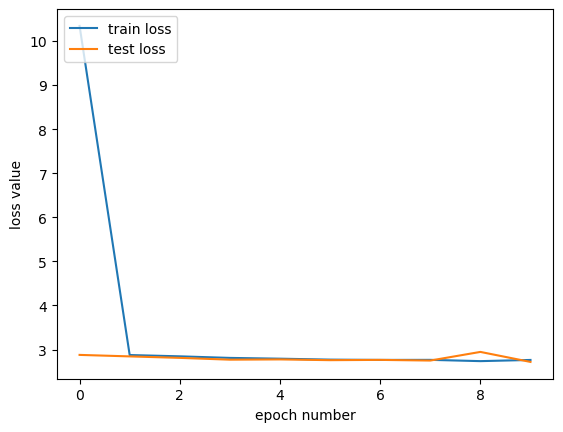

In [21]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

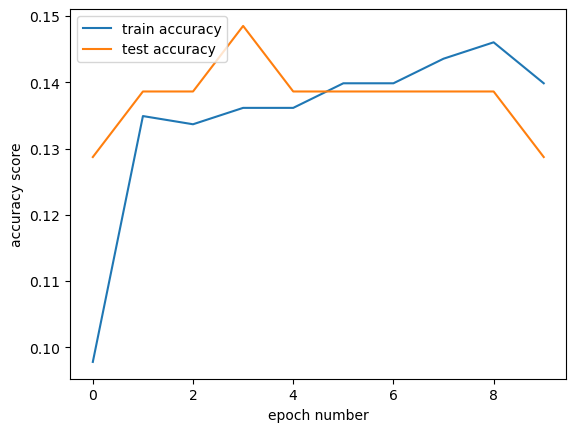

In [22]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 2

In [23]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_2 = model.fit(
        train_generator,
        verbose=0, validation_data = test_generator, 
        epochs=20)

2023-03-24 15:48:32.877727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-24 15:48:40.879919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


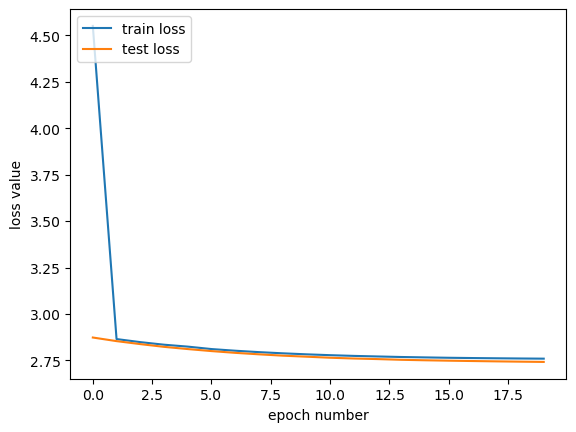

In [24]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

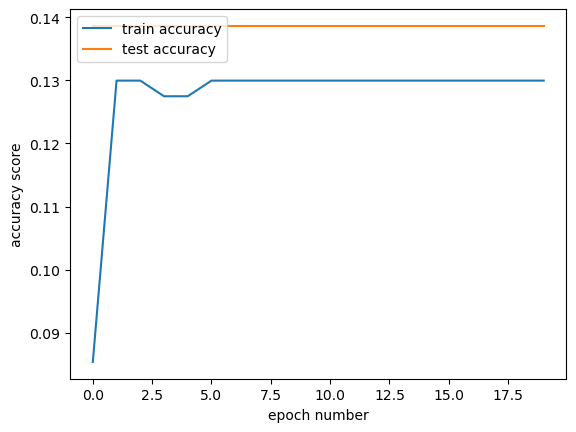

In [25]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 3

In [26]:
model_3 = model.fit(
        train_generator,
        verbose = 0, validation_data = test_generator, 
        epochs=50)

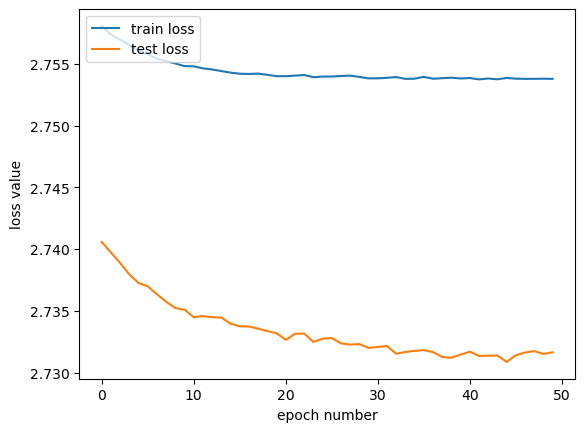

In [27]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

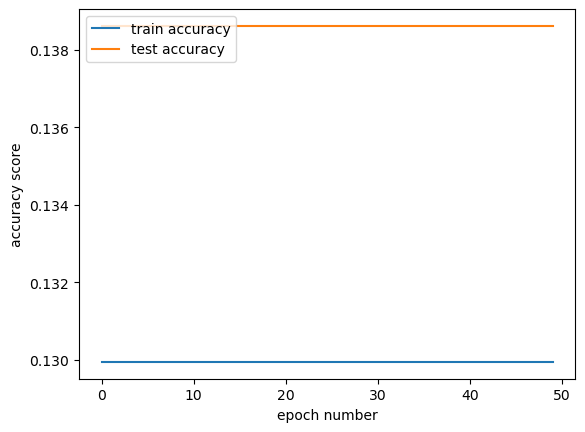

In [28]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 4

In [29]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_4 = model.fit(
        train_generator,
        verbose=0, validation_data = test_generator, 
        epochs=30)

2023-03-24 15:58:49.543281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-24 15:58:57.716119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


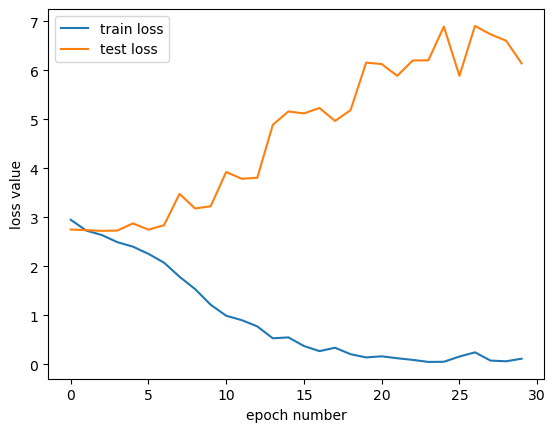

In [30]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

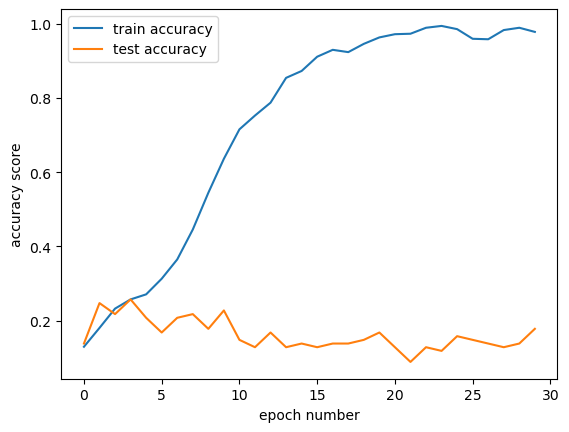

In [31]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");